In [33]:
%matplotlib inline  
import motor_compare as motor
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.stats import norm
from random import randint
from numpy import linalg as LA
import pfilter as pf
import seaborn as sns

In [34]:
# motor paremeters (single cage)
ra = 0.0138
xa = 0.083
xm = 3.0
r1 = 0.055
x1 = 0.053
H  = 1.0
D  = 1.0

In [35]:
# create a voltage 'perturbance'
tend = 3.0

# this data is taken from the 2-bus sytem example, we use pelec to initialize the motor
v_ds   = 1.0144
v_qs   = -0.0589
pelec  = 1.06484

steps = 1000
time  = np.linspace(0,tend,steps)
volt  = np.zeros((2, steps))

for i in range(len(time)):
    if (time[i] > 0.1) and (time[i] < 0.4):
        volt[0,i] = v_ds * 0.6
        volt[1,i] = v_qs * 0.6
    else:
        volt[0, i] = v_ds
        volt[1, i] = v_qs

In [36]:
# initialize cim5 and integrate

dim_a      = 5 #number of df
motor_a    = motor.cim5(ra, xa, xm, r1, x1, H, D)

x0          = np.ones(dim_a + 1)
sol         = optimize.root(motor_a.initialize, x0, args = (v_ds, v_qs, pelec))
motor_a.t_m = sol.x[5] #set mechanical torque with initialization results

x_a        = np.zeros((dim_a, steps))
x_a[:,0]   = sol.x[0:dim_a]
    

for i in range(len(time) - 1):
    motor_a.propagate(time[1], x_a[:, i], x_a[:, i + 1], volt[0, i + 1],
        volt[1, i + 1])
    
#save current and voltage in measurement variables
meas_curr = x_a[3:5, :]
meas_volt = volt

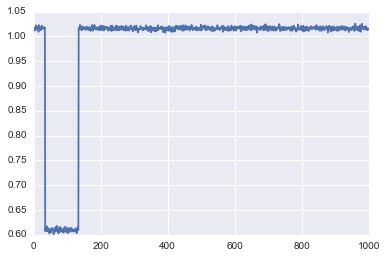

In [37]:
# Now, add some noise to voltage and current measurements
meas_var = 3e-3

for i in range(steps):
    meas_volt[0,i] += np.random.normal(0, meas_var)
    meas_volt[1,i] += np.random.normal(0, meas_var)
    meas_curr[0,i] += np.random.normal(0, meas_var)
    meas_curr[1,i] += np.random.normal(0, meas_var)
    
plt.plot(np.abs(meas_volt[0, :] + 1j*meas_volt[1, :]))

In [38]:
# Here we define functions that will be used to propagate the particles
meas_var = 8e-2
prior_var = 0.1
ws        = 2*np.pi*60

# assume we have good grip on states
def prior(x, w, mean):
    size = len(w)
    for i in range(size):
        x[0,i] = mean[0] + mean[0]*np.random.normal(0, prior_var)
        x[1,i] = mean[1] + mean[1]*np.random.normal(0, prior_var)
        x[2,i] = mean[2] + mean[2]*np.random.normal(0, 0.1*prior_var)

def measurement(theta, x, y, volt):
    size = y.shape[1]
    for i in range(size):
        diff1 = volt[0] - x[0, i]
        diff2 = volt[1] - x[1, i]
        den   = theta[0]**2 + theta[8]**2

        y[0, i] = (theta[0]*diff1 + theta[8]*diff2)/den + np.random.normal(0, meas_var)
        y[1, i] = (theta[0]*diff2 - theta[8]*diff1)/den + np.random.normal(0, meas_var)


def likelihood(w, y, meas_curr):
    size = y.shape[1]
    for i in range(size):
        w[i] = norm.pdf(y[0, i] - meas_curr[0], 0, meas_var)*norm.pdf(y[1, i] - meas_curr[1], 0, meas_var)
        
def propagate(theta, x, volt, h):
    
    size = x.shape[1]
    for i in range(size):
        
        # We calculate the currents here so we don't have to include
        # them as states
        diff1 = volt[0] - x[0, i]
        diff2 = volt[1] - x[1, i]
        den   = theta[0]**2 + theta[8]**2

        i_d = (theta[0]*diff1 + theta[8]*diff2)/den
        i_q = (theta[0]*diff2 - theta[8]*diff1)/den
        
        xold = x[:, i]
                
        x[0, i] = x[0, i] + h*((-1.0/theta[6])*(xold[0] + (theta[7] - theta[8])*i_q) + xold[2]*ws*xold[1])
        x[1, i] = x[1, i] + h*((-1.0/theta[6])*(xold[1] - (theta[7] - theta[8])*i_d) - xold[2]*ws*xold[0])
        x[2, i] = x[2, i] + h*((1.0/(2.0*theta[5]))*(theta[9] - xold[0]*i_d - xold[1]*i_q))
        
        # question: how we determine the noise?
        x[0, i] += np.random.normal(0, 0.01)
        x[1, i] += np.random.normal(0, 0.01)
        x[2, i] += np.random.normal(0, 0.001)

        
    
# filtering
nparticles = 200

# model parametes
tp      = (x1 + xm)/(r1*ws)
x0      = (xa + xm)
x_p     = xa + (x1*xm)/(x1 + xm)
t_m     = 1.04656437754

theta = [ra, xa, xm, r1, x1, H, tp, x0, x_p, t_m]

# we make the initial estimate imprecise
bias = 0.9
mean  = [bias*0.9280, bias*-0.1891, bias*0.06196]


# prior sampling
x_dim = 3
y_dim = 2
cl = pf.cloud(nparticles, x_dim, y_dim)


prior(cl.x, cl.w, mean)
measurement(theta, cl.x, cl.y, meas_volt[:, 0])

likelihood(cl.w, cl.y, meas_curr[:, 0])
pf.normalize(cl.w)

print np.average(cl.x[1,:],axis = 0, weights=cl.w)

-0.184432079495


In [39]:
# time loop

exp_n = np.zeros((x_dim, len(time)))
p_tra = np.zeros((nparticles, len(time)))

for i in range(len(time) - 1):
    v    = meas_volt[:, i + 1]
    cl.x = pf.resample_systematic(cl.w, cl.x)
    cl.w = (1.0/nparticles)*np.ones(nparticles)
    propagate(theta, cl.x, v, time[1])
    measurement(theta, cl.x, cl.y, v)
    likelihood(cl.w, cl.y, meas_curr[:, i + 1])
    pf.normalize(cl.w)
    exp_n[0, i] = np.average(cl.x[0,:], axis = 0, weights=cl.w)
    exp_n[1, i] = np.average(cl.x[1,:], axis = 0, weights=cl.w)
    exp_n[2, i] = np.average(cl.x[2,:], axis = 0, weights=cl.w)
    p_tra[:,i] = cl.x[2,:]

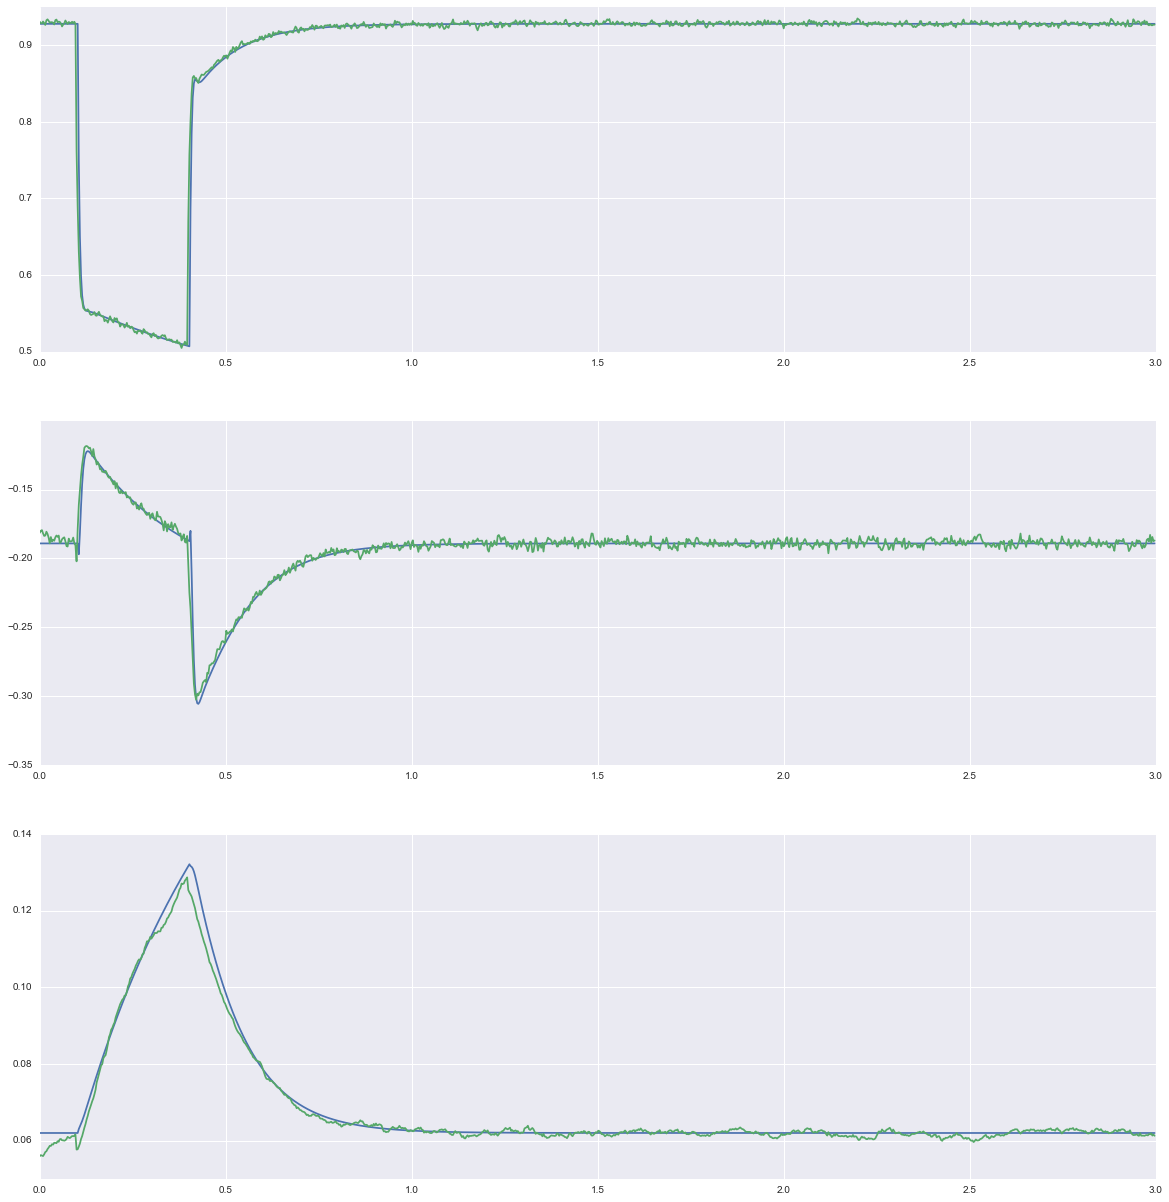

In [40]:
f, axes = plt.subplots(3, 1, figsize=(20, 21))

axes[0].plot(time[:-1], x_a[0,:-1])
axes[0].plot(time[:-1], exp_n[0,:-1])

axes[1].plot(time[:-1], x_a[1,:-1])
axes[1].plot(time[:-1], exp_n[1,:-1])

axes[2].plot(time[:-1], x_a[2,:-1])
axes[2].plot(time[:-1], exp_n[2,:-1])